In [36]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
from scipy import stats
from scipy import optimize
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans

import pickle
import datetime

In [90]:
today = datetime.date.today()
today

datetime.date(2020, 9, 7)

# Prep data

In [2]:
def turn_cluster_labels_to_knn(cluster_labels, uniq_labels):
    """
    """
    
    clst_idx = snmcseq_utils.get_index_from_array(uniq_labels, cluster_labels)
    m, n = len(clst_idx), len(uniq_labels)
    _i = np.arange(m)
    _j = clst_idx
    _data = [1]*m
    knn = sparse.coo_matrix((_data, (_i, _j)), shape=(m, n)) 
    return knn

In [52]:
def calc_r_threshold(bins, cdf, cdf_shuff):
    """
    """
    # fdr
    fdr = cdf_shuff/(cdf+1e-7)
    # get r_threshold
    # remove nan
    isnan = np.isnan(fdr)
    _y = fdr[~isnan]
    _x = bins[1:][~isnan]
    
    # find r threshold
    f = lambda _x_func: np.interp(_x_func, _x, _y) - fdr_threshold
    if f(-1)*f(0) < 0:
        sol = optimize.root_scalar(f, bracket=(-1, 0))
        if sol:
            return sol.root
        else:
            print("failed to detect r_threshold: ", tag)
            return np.nan
    else:
        print("failed to detect r_threshold:", tag)
        return np.nan 

def get_linked_pairs_stats(enhancer_gene_to_eval, 
                           to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells,
                           bins,
                           distance_threshold=100000,
                           fdr_threshold=0.2,
                           tag=""):
    """
    """
    
    # dists 
    dists = enhancer_gene_to_eval.loc[to_correlate, 'dist'].values

    ## sig numbers
    label_cond = dists < distance_threshold
    track = corrs[label_cond]

    ### total numbers with the condition
    num_total_pairs = len(enhancer_gene_to_eval[to_correlate][label_cond])
    num_total_genes = len(enhancer_gene_to_eval[to_correlate][label_cond]['gene'].unique())
    num_total_enhs = len(enhancer_gene_to_eval[to_correlate][label_cond]['ens'].unique())

    # hist
    hist, _ = np.histogram(track, bins=bins, density=True)
    cdf = np.cumsum(hist)
    
    # hist_shuff 
    hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, density=True)
    cdf_shuff = np.cumsum(hist_shuff)
    
    # hist_shuff_cells
    hist_shuff_cells, _ = np.histogram(corrs_shuffled_cells, bins=bins, density=True)
    cdf_shuff_cells = np.cumsum(hist_shuff_cells)
    
    # find r threshold
    r_threshold = calc_r_threshold(bins, cdf, cdf_shuff)
    # num stats
    if not np.isnan(r_threshold):
        sig_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold]
        # num_sig
        num_sig_pairs = len(sig_table)
        num_sig_genes = len(sig_table['gene'].unique()) 
        num_sig_enhs = len(sig_table['ens'].unique()) 
    else:
        sig_table, num_sig_pairs, num_sig_genes, num_sig_enhs = np.nan, np.nan, np.nan, np.nan
    
    # find r threshold
    r_threshold_shuff_cells = calc_r_threshold(bins, cdf, cdf_shuff_cells)
    # num stats
    if not np.isnan(r_threshold_shuff_cells):
        corr_table = enhancer_gene_to_eval[to_correlate][label_cond][track<r_threshold_shuff_cells]
        # num_corr
        num_corr_pairs = len(corr_table)
        num_corr_genes = len(corr_table['gene'].unique()) 
        num_corr_enhs = len(corr_table['ens'].unique()) 
    else:
        corr_table, num_corr_pairs, num_corr_genes, num_corr_enhs = np.nan, np.nan, np.nan, np.nan
    
    
    return {
        'num_total_pairs': num_total_pairs,
        'num_total_genes': num_total_genes,
        'num_total_enhs': num_total_enhs,
        
        'r_threshold': r_threshold,
        'num_sig_pairs': num_sig_pairs,
        'num_sig_genes': num_sig_genes,
        'num_sig_enhs': num_sig_enhs,
        'sig_table': sig_table,
        
        'r_threshold': r_threshold_shuff_cells,
        'num_corr_pairs': num_corr_pairs,
        'num_corr_genes': num_corr_genes,
        'num_corr_enhs': num_corr_enhs,
        'corr_table': corr_table,
    }

In [3]:
ti = time.time()

inputs = [
    'mat_mcg_snmcseq_gene.npz',
    'mat_cg_snmcseq_gene.npz',
    'enh.tsv',
    'cell_snmcseq_gene.txt',
]

input_dir = '/cndd2/fangming/projects/scf_enhancers/data/organized_cell_level/version_aug25'
mats = []

for _input in inputs:
    f = os.path.join(input_dir, _input)
    with open(f, 'rb') as fh:
        mats.append(pickle.load(fh))
        print(time.time() - ti)

(mat_mcg, mat_cg, mat_enh, mat_cell) = mats

12.467839241027832
33.35457396507263
33.404112577438354
33.427815198898315


In [4]:
print(
    mat_mcg.shape, 
    mat_cg.shape, 
    mat_enh.shape, 
    mat_cell.shape, 
    )

(233514, 9931) (233514, 9931) (233514, 3) (9931,)


In [5]:
# cell cluster information and turn it into kNNs
# feed it into knn matrices below
# compare with the version with no duplication

f = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_clusterings.tsv'
df_clst = pd.read_csv(f, sep='\t').set_index('sample')
print(df_clst.shape)
df_clst.head()

(408885, 10)


/cndd2/fangming/venvs/routine/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3071: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,joint_embedding_x,joint_embedding_y,modality,modality_name,single_modality_cluster,single_modality_annot,joint_cluster_round1,joint_cluster_round2,joint_cluster_round3,joint_cluster_round4
sample,,,,,,,,,,
snmcseq_gene_2C_M_0,0.471629,-3.134735,snmcseq_gene,DNA methylation,L4-IT-Rorb_Rorb-Tenm2,L4-IT-Rorb_Rorb-Tenm2,1,1-1,1-1-1,1-1-1-1
snmcseq_gene_2C_M_1,-2.414973,-12.098081,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4,4-2,4-2-1,4-2-1-1
snmcseq_gene_2C_M_100,-1.446751,-12.051894,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4,4-1,4-1-1,4-1-1-1
snmcseq_gene_2C_M_1000,-1.901734,-13.660591,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4,4-2,4-2-1,4-2-1-1
snmcseq_gene_2C_M_1001,-0.981086,-11.936621,snmcseq_gene,DNA methylation,L23-IT-Cux2,L23-IT-Cux2,4,4-1,4-1-1,4-1-1-1


In [99]:
f = "/cndd/fangming/CEMBA/data/MOp_all/results_final/cluster_annotation_scf_round2.tsv"
df_annot = pd.read_csv(f, sep='\t')
print(df_annot.shape)
df_annot.head()

(29, 3)


,cluster,annot,color
0,1-1,L4/5 IT (1),#3CBC78
1,1-2,L4/5 IT (2-3),#3CBC45
2,2-1,L6 CT Cpa6,#338C5E
3,2-2,L6 CT Cpa6_Gpr139,#338C5E
4,2-3,L6 CT Nxph2,#3E766C


In [6]:
common_cell = np.intersect1d(mat_cell, df_clst[df_clst['modality']=='snmcseq_gene'].index.values)
print(mat_cell.shape, common_cell.shape)

(9931,) (9364,)


In [7]:
uniq_labels = df_clst.reindex(common_cell)['joint_cluster_round2'].unique()
knn_xz = turn_cluster_labels_to_knn(
    df_clst.reindex(common_cell)['joint_cluster_round2'].values, 
    uniq_labels,
)

common_cell_idx = snmcseq_utils.get_index_from_array(mat_cell, common_cell)

mat_mcg = mat_mcg.tocsc()[:, common_cell_idx] 
mat_cg = mat_cg.tocsc()[:, common_cell_idx] 

print(mat_mcg.shape, mat_cg.shape, knn_xz.shape)

(233514, 9364) (233514, 9364) (9364, 29)


In [8]:
ti = time.time()

# enhancer by metacell
ec_cg = mat_cg.dot(knn_xz).todense() 
ec_mcg = mat_mcg.dot(knn_xz).todense()  

print(time.time()-ti)

print(ec_cg.shape, ec_mcg.shape)

3.388960599899292
(233514, 29) (233514, 29)


In [9]:
# get mcc
ti = time.time()
ec_mccg = snmcseq_utils.get_mcc_lite_v4(
                                pd.DataFrame(ec_cg).astype(np.float32), 
                                pd.DataFrame(ec_mcg).astype(np.float32), 
                                base_call_cutoff=5, sufficient_coverage_fraction=0.8, fillna=True)

print(time.time()-ti)
print(ec_mccg.shape)
ec_mccg.columns = uniq_labels
ec_mccg.head()


0.3162040710449219
(143526, 29)


,1-1,4-2,4-1,6-2,1-2,6-4,3-1,3-2,5-3,2-1,...,2-3,6-6,6-3,3-3,9-1,10-1,5-5,8-2,8-3,8-1
1,0.956594,0.918060,0.904472,0.341667,0.959514,0.281250,0.958425,0.979381,0.664122,0.960000,...,0.961749,0.357143,0.814815,0.937500,1.000000,0.833333,0.863414,0.952381,0.863414,0.973684
3,0.525126,0.422785,0.401442,0.052083,0.400631,0.220339,0.215426,0.359281,0.903226,0.103933,...,0.240000,0.441620,0.452381,0.571429,0.058824,0.441620,0.441620,0.272727,0.441620,0.043478
6,0.239130,0.273585,0.241245,0.020000,0.219298,0.125000,0.236515,0.180556,0.188406,0.153846,...,0.262500,0.256806,0.500000,0.250000,0.333333,0.256806,0.222222,0.461538,0.256806,0.250000
10,0.519637,0.156923,0.273050,0.073529,0.187943,0.000000,0.327645,0.140468,0.365385,0.165975,...,0.303371,0.833333,0.826087,0.625000,0.000000,0.857143,0.385301,0.230769,0.385301,0.300000
18,0.894819,0.897163,0.903814,0.216216,0.922374,0.171875,0.920277,0.922652,0.753623,0.934307,...,0.963636,0.333333,0.857143,1.000000,1.000000,0.802152,0.802152,0.720000,0.802152,0.884615


# Cluster

In [11]:
ec_mccg_zscore = stats.zscore(ec_mccg.values, axis=1, ddof=0,)
ec_mccg_zscore = pd.DataFrame(
    ec_mccg_zscore,
    index=ec_mccg.index,
    columns=ec_mccg.columns,
)

In [12]:
# generate cluster order 
Z = sch.linkage(ec_mccg_zscore.T.values, method='ward', optimal_ordering=True)
g = sch.dendrogram(Z, no_plot=True)
clst_orders = np.array(g['ivl']).astype(int)

In [60]:
# generate enhancer clusters
ti = time.time()

kmeans = KMeans(n_clusters=10)
enh_clsts = kmeans.fit_predict(ec_mccg_zscore.values)
enh_orders = np.argsort(enh_clsts)
_, enh_clst_counts = np.unique(enh_clsts, return_counts=True) # sorted already

print(enh_clsts.shape)
print(time.time() - ti)

(143526,)
15.854960680007935


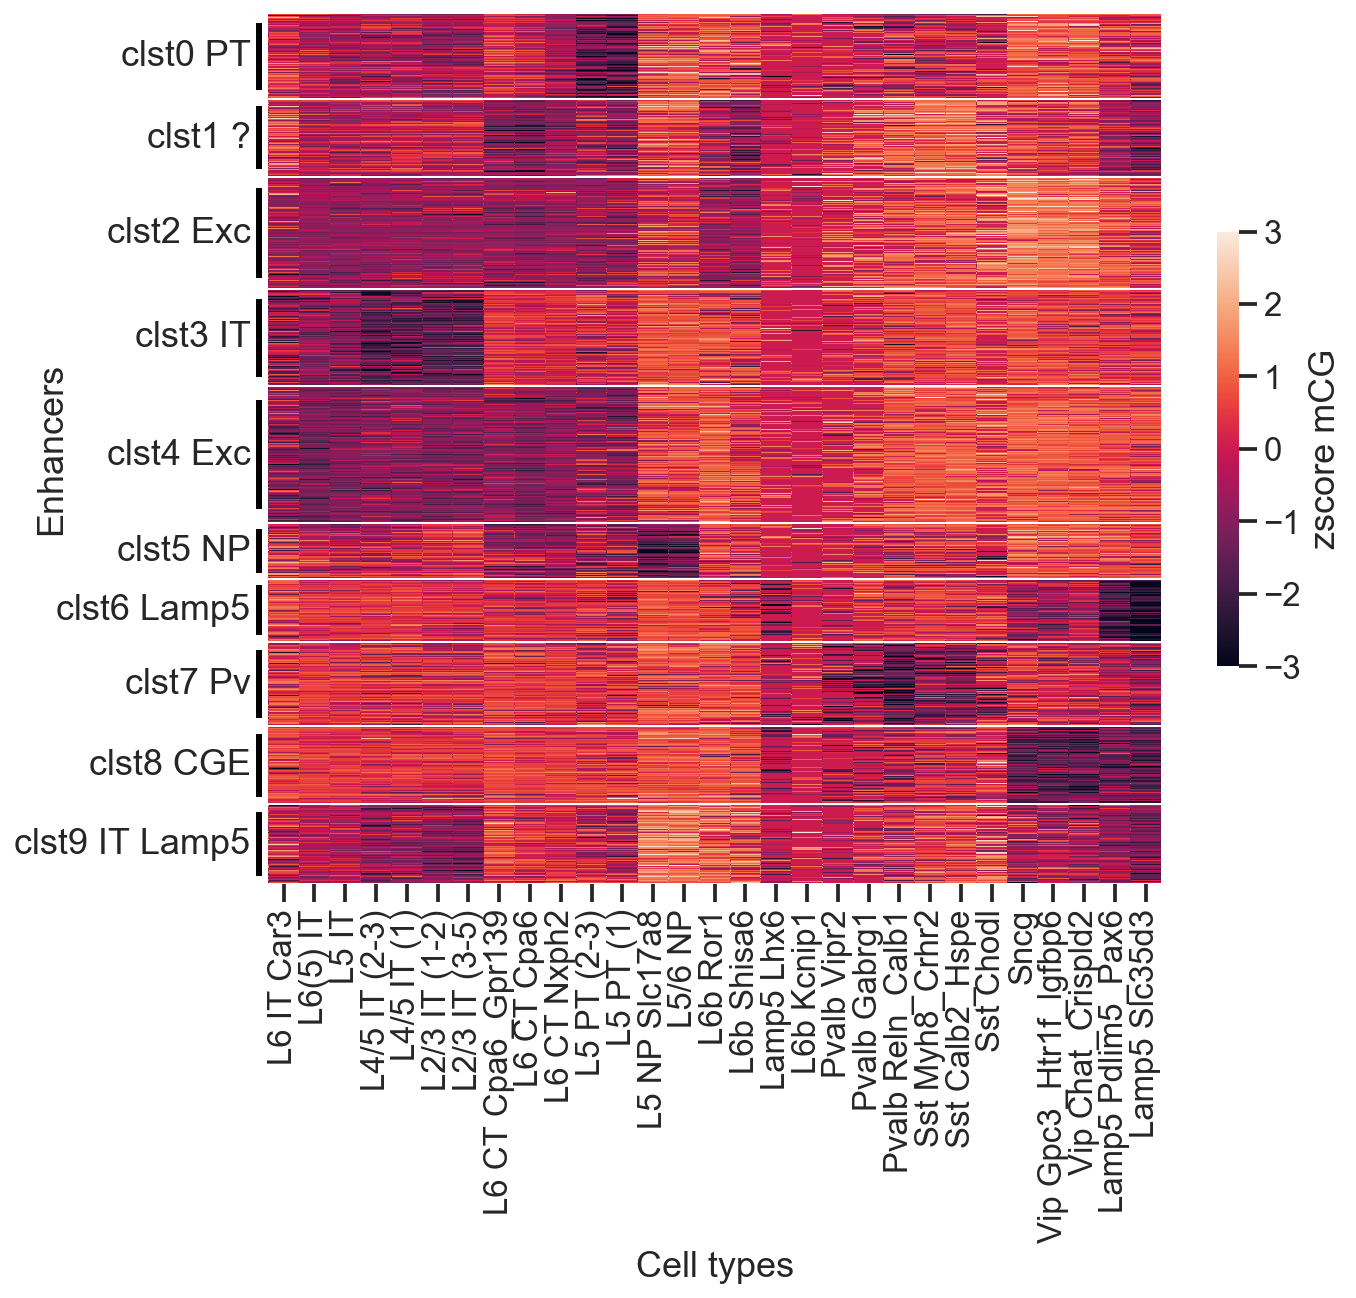

5.3829429149627686


In [121]:
ti = time.time()

enh_clst_annot = {
    0: "PT",
    1: "?",
    2: "Exc",
    3: "IT",
    4: "Exc",
    5: "NP",
    6: "Lamp5",
    7: "Pv",
    8: "CGE",
    9: "IT Lamp5",
}



fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(ec_mccg_zscore.values[enh_orders][:, clst_orders], 
            xticklabels=df_annot.set_index('cluster').loc[uniq_labels[clst_orders], 'annot'],
            yticklabels=False,
            ax=ax, vmax=3, vmin=-3, 
            cbar_kws={'label': 'zscore mCG', 'shrink': 0.5}
           )

# line and annotate lines
ynums = np.cumsum(enh_clst_counts)
for i in np.arange(len(ynums)):
    ax.vlines(-0.01*len(clst_orders), 
              ymin=ynums[i]+(-1+0.1)*enh_clst_counts[i], 
              ymax=ynums[i]+(-0.1)*enh_clst_counts[i], 
              clip_on=False,
              color='k', linewidth=3)
    ax.text(-0.02*len(clst_orders), ynums[i]-(0.5)*enh_clst_counts[i], 
            'clst{} '.format(i)+enh_clst_annot[i],
            ha='right',
            va='center',
           )

ax.hlines(np.cumsum(enh_clst_counts), xmin=0, xmax=len(clst_orders), color='white', linewidth=1)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel('Cell types')
ax.set_ylabel('Enhancers', labelpad=100)
plt.show()

print(time.time() - ti)


# linked and correlated enhancers

In [41]:
# inputs
input_enh_gene_table = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv' 
input_corr = '/cndd2/fangming/projects/scf_enhancers/results_final/2020-09-06_corrs_test1.pkl' 
enhancer_gene_to_eval = pd.read_csv(input_enh_gene_table, sep='\t')[['gene', 'ens', 'dist']]
print(enhancer_gene_to_eval.shape)

# results
with open(input_corr, 'rb') as fh:
    to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells = pickle.load(fh)
print(to_correlate.shape, corrs.shape, corrs_shuffled.shape, corrs_shuffled_cells.shape)

(2589994, 3)
(2589994,) (2586286,) (2586286,) (2586286,)


In [55]:
# sig, corr, stats
num_bins = 200
bin_min, bin_max = -1, 0.5
bins = np.linspace(bin_min, bin_max, num_bins)

dist_th = 100000
fdr_th = 0.2

res_dict = get_linked_pairs_stats(enhancer_gene_to_eval, 
                                  to_correlate, corrs, corrs_shuffled, corrs_shuffled_cells,
                                  bins, 
                                  distance_threshold=dist_th,
                                  fdr_threshold=fdr_th,
                                  tag="")
res_dict

{'num_total_pairs': 242076,
 'num_total_genes': 18051,
 'num_total_enhs': 100716,
 'r_threshold': -0.01602913308264853,
 'num_sig_pairs': 5905,
 'num_sig_genes': 828,
 'num_sig_enhs': 5593,
 'sig_table':                        gene     ens   dist
 1540     ENSMUSG00000000126   35953   4552
 1541     ENSMUSG00000000126   35954   5567
 1542     ENSMUSG00000000126   35955   6403
 1545     ENSMUSG00000000126   35961  18096
 4762     ENSMUSG00000000247  124464  21496
 ...                     ...     ...    ...
 2511399  ENSMUSG00000109372  207637  37251
 2511403  ENSMUSG00000109372  207645  12105
 2577582  ENSMUSG00000113429   48347  11834
 2577583  ENSMUSG00000113429   48348  13133
 2577584  ENSMUSG00000113429   48349  18614
 
 [5905 rows x 3 columns],
 'num_corr_pairs': 153421,
 'num_corr_genes': 16947,
 'num_corr_enhs': 80689,
 'corr_table':                        gene     ens   dist
 94       ENSMUSG00000000001  147662  92177
 95       ENSMUSG00000000001  147663  91955
 96       ENSMUSG

In [83]:
sig_enhs = np.unique(res_dict['sig_table']['ens'].values)
corr_enhs = np.unique(res_dict['corr_table']['ens'].values)
print(sig_enhs.shape, corr_enhs.shape, sig_enhs[:5], corr_enhs[:5])

(5593,) (80689,) [276 278 280 281 282] [44 45 47 51 57]


# all, correlated, linked (for each enh cluster)

In [85]:

enh_lookup = pd.DataFrame(index=ec_mccg_zscore.index)
enh_lookup['enh_cluster'] = enh_clsts 
print(enh_lookup.shape)
enh_lookup.head()

(143526, 1)


,enh_cluster
1,6
3,1
6,0
10,1
18,6


In [96]:
mat_enh['chrom'] = "chr"+mat_enh['chr']
mat_enh_output = mat_enh[['chrom', 'start', 'end']]
print(mat_enh_output.shape)
mat_enh_output.head()


(233514, 3)


,chrom,start,end
0,chr1,3083769,3083816
1,chr1,3112234,3112467
2,chr1,3112770,3112986
3,chr1,3113717,3114035
4,chr1,3118790,3118935


In [97]:
output_format = ('/cndd2/fangming/projects/scf_enhancers/results/for_motifs/'
                '{}_enhancer_list_{}clusters_clst{{}}_{{}}.bed'.format(today, len(np.unique(enh_clsts)))
                )

for enh_clst, df_sub in enh_lookup.groupby('enh_cluster'):
    sub_all_enhs = df_sub.index.values
    sub_corr_enhs = np.intersect1d(sub_all_enhs, corr_enhs) 
    sub_sig_enhs = np.intersect1d(sub_all_enhs, sig_enhs) 
    
    print(enh_clst,
          sub_all_enhs.shape, 
          sub_corr_enhs.shape,
          sub_sig_enhs.shape,
         ) 
    
    f = output_format.format(enh_clst, 'all')
    mat_enh_output.reindex(sub_all_enhs).to_csv(f, sep='\t', header=False, index=False)
    
    f = output_format.format(enh_clst, 'correlated')
    mat_enh_output.reindex(sub_corr_enhs).to_csv(f, sep='\t', header=False, index=False)
    
    f = output_format.format(enh_clst, 'linked')
    mat_enh_output.reindex(sub_sig_enhs).to_csv(f, sep='\t', header=False, index=False)
    

0 (13947,) (6968,) (152,)
1 (12948,) (7016,) (306,)
2 (18459,) (10571,) (1233,)
3 (16087,) (8702,) (666,)
4 (22532,) (12913,) (1377,)
5 (9188,) (5052,) (300,)
6 (10420,) (4015,) (160,)
7 (13941,) (5559,) (423,)
8 (12894,) (4505,) (412,)
9 (13110,) (6786,) (134,)
